Author : Iklima Mardiana

Dataset : https://www.kaggle.com/datasets/szrlee/stock-time-series-20050101-to-20171231

In [171]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [172]:
df = pd.read_csv('BA_2006-01-01_to_2018-01-01.csv')
df

,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,70.40,70.60,69.33,70.44,4943100,BA
1,2006-01-04,70.08,71.27,69.86,71.17,3165000,BA
2,2006-01-05,70.55,70.55,69.58,70.33,4598300,BA
3,2006-01-06,70.34,70.50,69.05,69.35,4820200,BA
4,2006-01-09,69.28,69.40,68.66,68.77,4567700,BA
...,...,...,...,...,...,...,...
3015,2017-12-22,296.33,296.52,293.01,295.10,2257350,BA
3016,2017-12-26,295.54,297.44,294.65,295.36,1394737,BA
3017,2017-12-27,296.41,296.80,294.80,295.62,1447837,BA
3018,2017-12-28,295.81,296.99,294.74,296.35,1436751,BA


In [173]:
df.isna().sum()

Date      0
Open      1
High      1
Low       1
Close     0
Volume    0
Name      0
dtype: int64

In [174]:
df.dropna(axis=0, inplace=True)

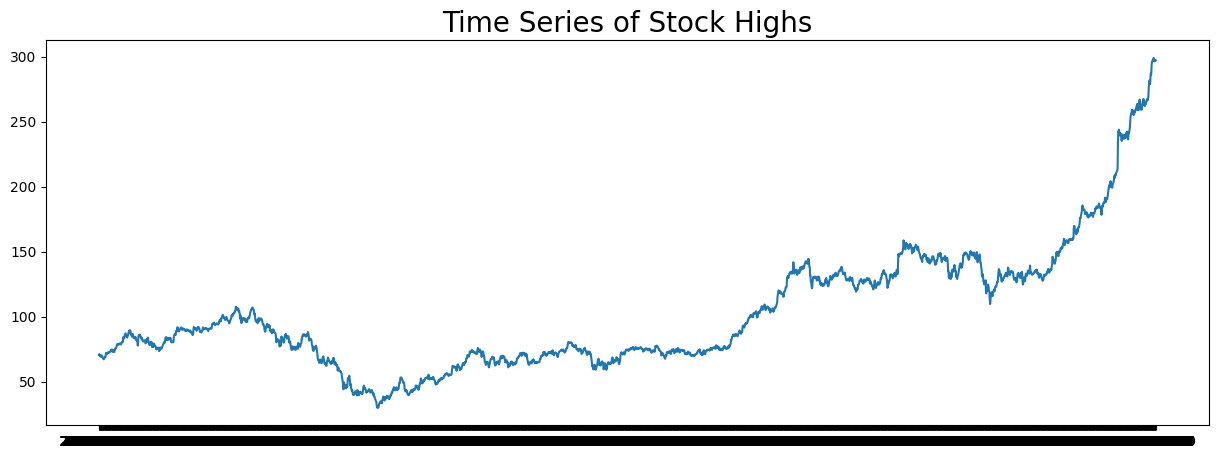

In [175]:
dates = df['Date'].values
stock = df['High'].values

plt.figure(figsize=(15,5))
plt.plot(dates, stock)
plt.title('Time Series of Stock Highs',
          fontsize=20);

In [176]:
df['Date'] = pd.to_datetime(df['Date'])
dataset = df.set_index('Date')

In [177]:
stock = stock.reshape(-1,1)
stock

array([[ 70.6 ],
       [ 71.27],
       [ 70.55],
       ...,
       [296.8 ],
       [296.99],
       [297.3 ]])

In [178]:
scaler = MinMaxScaler()
stock = scaler.fit_transform(stock)

In [179]:
X_train, X_test, y_train, y_test = train_test_split(stock, dates,
                                                    test_size=0.2,
                                                    shuffle=False)

In [180]:
print('Number of Data Train : ',len(X_train))
print('Number of Data Validation : ',len(X_test))

Number of Data Train :  2415
Number of Data Validation :  604


mengubah data menjadi format yang dapat diterima oleh model

In [181]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [182]:
train_set = windowed_dataset(X_train, window_size=60, batch_size=64, shuffle_buffer=1000)
test_set  = windowed_dataset(X_test, window_size=128, batch_size=64, shuffle_buffer=1000)

Arsitektur model menggunakan 2 buah layer LSTM

In [183]:
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(65, return_sequences=True, input_shape = [None, 1]),
  tf.keras.layers.LSTM(65),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
])

In [184]:
threshold_mae = (stock.max() - stock.min()) * 10/100
print(threshold_mae)

0.09999999999999998


mengimplementasikan callback ketika MAE < 10%

In [185]:
class myCallback(tf.keras.callbacks.Callback):
  def __init__(self, min_epochs=10):
    self.min_epochs = min_epochs
    self.epochs_passed = 0

  def on_epoch_end(self, epoch, logs={}):
    self.epochs_passed += 1

    if self.epochs_passed >= self.min_epochs and logs.get('mae') < threshold_mae:
      print(f"MAE < 10% after {self.epochs_passed} epochs.")
      self.model.stop_training = True

callbacks = myCallback()

In [186]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(train_set,
                    epochs=100,
                    validation_data=test_set,
                    verbose=2,
                    callbacks=[callbacks])

Epoch 1/100
37/37 - 9s - loss: 0.0295 - mae: 0.2173 - val_loss: 0.1810 - val_mae: 0.5709 - 9s/epoch - 255ms/step
Epoch 2/100
37/37 - 4s - loss: 0.0257 - mae: 0.1992 - val_loss: 0.1705 - val_mae: 0.5494 - 4s/epoch - 111ms/step
Epoch 3/100
37/37 - 4s - loss: 0.0234 - mae: 0.1874 - val_loss: 0.1630 - val_mae: 0.5382 - 4s/epoch - 120ms/step
Epoch 4/100
37/37 - 5s - loss: 0.0217 - mae: 0.1780 - val_loss: 0.1569 - val_mae: 0.5252 - 5s/epoch - 140ms/step
Epoch 5/100
37/37 - 4s - loss: 0.0202 - mae: 0.1697 - val_loss: 0.1520 - val_mae: 0.5184 - 4s/epoch - 112ms/step
Epoch 6/100
37/37 - 6s - loss: 0.0188 - mae: 0.1621 - val_loss: 0.1475 - val_mae: 0.5095 - 6s/epoch - 154ms/step
Epoch 7/100
37/37 - 4s - loss: 0.0176 - mae: 0.1551 - val_loss: 0.1434 - val_mae: 0.5019 - 4s/epoch - 121ms/step
Epoch 8/100
37/37 - 4s - loss: 0.0165 - mae: 0.1488 - val_loss: 0.1396 - val_mae: 0.4936 - 4s/epoch - 113ms/step
Epoch 9/100
37/37 - 6s - loss: 0.0155 - mae: 0.1429 - val_loss: 0.1360 - val_mae: 0.4845 - 6s/ep

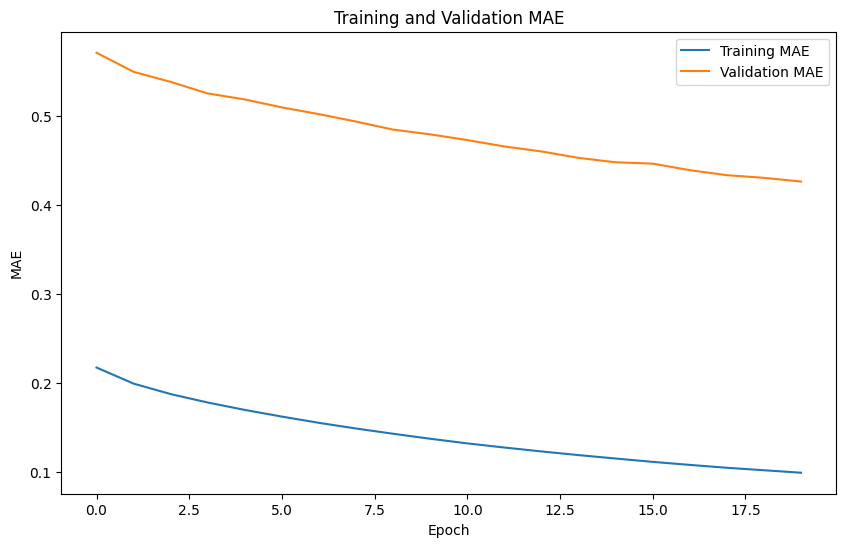

In [189]:

plt.figure(figsize=(10, 6))
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()


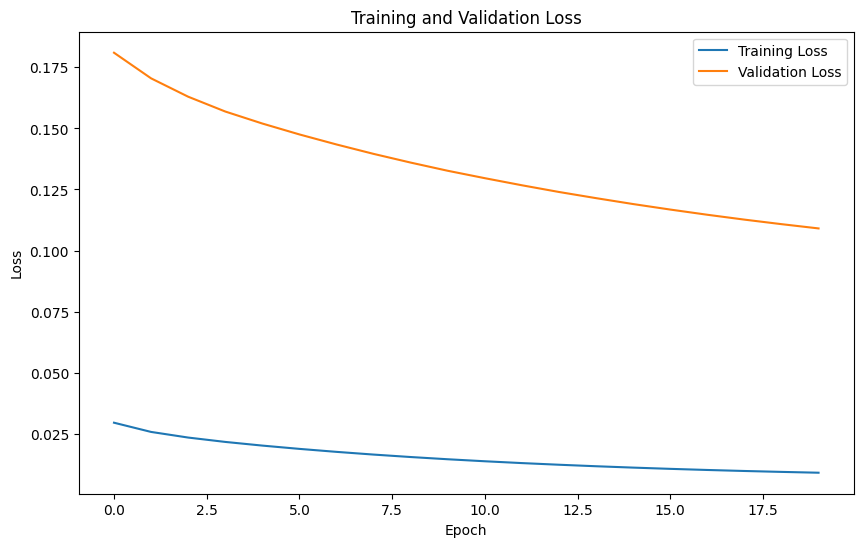

In [190]:

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()